In [2]:
import os #for system level directory manipulations.
import torch #base package for tensor support.
import pickle #for storing the reports in a python efficient manner.
import numpy as np #base package for underlying numerical computations.
import matplotlib.pyplot as plt #base package for data visualization.

from torch import nn #nn module for creating neural nets.
from torch.utils.data import DataLoader #for memory and compute efficient handling of datasets, for batching etc.
from torch.utils.data import random_split #for train-validation dataset splitting.

from torchvision import datasets #for publically available vision datasets.
from torchvision import transforms #for creating transforms that can be applied on the fly to each sample in a dataset. 

from collections import OrderedDict #data structure for creating the nn sequential model.

In [3]:
# checking if the gpu support is available through cuda.
gpu = torch.cuda.is_available()
print(f"GPU Available : {gpu}")

# checking if macOS metal backend is avaialble.
mps = torch.backends.mps.is_available()
print(f"MacOS Metal Backend Avaialble : {mps}")

# set the appropriate device to ensure hardware agnostic portable source code.
device = 'cuda' if gpu else 'mps' if mps else 'cpu'
print(f"Setting the default device to : ", device)


GPU Available : True
MacOS Metal Backend Avaialble : False
Setting the default device to :  cuda


In [4]:
#create a hyper-parameter dictionary for the network.
param_dict = dict()
param_dict["batch_size"] = 64
param_dict["num_epochs"] = 10
param_dict["lr"] = 1e-3
param_dict["num_layers"] = 3
param_dict["inp_size"] = 28 * 28
layer_size_list = [512, 512, 10]
param_dict["layer_size"] = {str(i):layer_size_list[i] for i in range(param_dict["num_layers"])}

In [5]:

# define the path structure of the data.
data_path = os.path.abspath("./data")
train_data_path = os.path.join(data_path, "train")
test_data_path = os.path.join(data_path, "test")

# define the path structure of the outputs.
out_path = os.path.abspath("./out")
model_out_path = os.path.join(data_path, "model")
report_out_path = os.path.join(data_path, "report")

# create the path structure if necessary.
os.makedirs(train_data_path, exist_ok=True)
os.makedirs(test_data_path, exist_ok=True)
os.makedirs(model_out_path, exist_ok=True)
os.makedirs(report_out_path, exist_ok=True)

# create the transform/target_transform from a list of transforms.
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# create the test/train dataset objects.
train_data = datasets.FashionMNIST(
    root=train_data_path, train=True, download=True, transform=train_transform)
test_data = datasets.FashionMNIST(
    root=test_data_path, train=False, download=True, transform=test_transform)

#split the train data into a validation and training set.
data_len = len(train_data)
val_split = 0.2
val_len = int(np.floor(val_split * data_len))
train_len = data_len - val_len

train_data, val_data = random_split(train_data, [train_len, val_len])

# create the train, validation and test dataloader objects for batching and efficient loading.
train_loader = DataLoader(train_data, batch_size=param_dict["batch_size"])
val_loader = DataLoader(val_data, batch_size=param_dict["batch_size"])
test_loader = DataLoader(test_data, batch_size=param_dict["batch_size"])


100.0%


Extracting /home/arun/projects/old/pytorch_networks/data/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/arun/projects/old/pytorch_networks/data/train/FashionMNIST/raw



100.0%


Extracting /home/arun/projects/old/pytorch_networks/data/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/arun/projects/old/pytorch_networks/data/train/FashionMNIST/raw



100.0%


Extracting /home/arun/projects/old/pytorch_networks/data/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/arun/projects/old/pytorch_networks/data/train/FashionMNIST/raw



100.0%


Extracting /home/arun/projects/old/pytorch_networks/data/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/arun/projects/old/pytorch_networks/data/train/FashionMNIST/raw



100.0%


Extracting /home/arun/projects/old/pytorch_networks/data/test/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/arun/projects/old/pytorch_networks/data/test/FashionMNIST/raw



100.0%


Extracting /home/arun/projects/old/pytorch_networks/data/test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/arun/projects/old/pytorch_networks/data/test/FashionMNIST/raw



100.0%


Extracting /home/arun/projects/old/pytorch_networks/data/test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/arun/projects/old/pytorch_networks/data/test/FashionMNIST/raw



100.0%

Extracting /home/arun/projects/old/pytorch_networks/data/test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/arun/projects/old/pytorch_networks/data/test/FashionMNIST/raw



In [6]:
#create the neural network model as a subclass of nn.Module of pytorch.
class FashionMNISTNet(nn.Module):
    def __init__(self, param_dict):
        super().__init__()
        self.flatten = nn.Flatten()
        self.param_dict = param_dict
        module_list = self.get_nn_modules()

        self.dense_relu_module = nn.Sequential(module_list)
    
    def get_nn_modules(self):
        """ 
        Defines the architecture of the nn block.
        Architecture logic should be an ordered dictionary. 
        """
        module_list = OrderedDict() #container for holding all the submodules of the block.
        
        #add the layers till the last layer.
        for idx in range(self.param_dict["num_layers"] - 1):
            inp_size = self.param_dict["inp_size"] if idx < 1 else self.param_dict["layer_size"][str(idx - 1)]
            out_size = self.param_dict["layer_size"][str(idx)]

            module_list[str(2 * idx)] = nn.Linear(inp_size, out_size)
            module_list[str(2 * idx + 1)] = nn.ReLU()
        
        #add the final layer.
        inp_size = self.param_dict["layer_size"][str(idx)]
        out_size = self.param_dict["layer_size"][str(idx + 1)]
        module_list[str(2 * self.param_dict["num_layers"])] = nn.Linear(inp_size, out_size)

        return module_list

    def forward(self, X):
        """
        Defines the forward pass of the nn model
        """
        X = self.flatten(X)
        logits = self.dense_relu_module(X)
        return logits

In [7]:
#create the neural network model.
model = FashionMNISTNet(param_dict).to(device)
#choose the criterion based on which training should be performed.
loss_fn = nn.CrossEntropyLoss()
#choose the optimizer for reducing the above criterion on the training set.
optimizer = torch.optim.SGD(model.parameters(), lr=param_dict["lr"])

In [8]:
def training_loop(data_loader, model, loss_fn, optimizer, device):
    """
    Defines a single loop through the entire training data.
    """
    train_report = {"loss": 0, "num_true": 0, "num_total": 0}

    total_loss = 0
    num_true = 0
    num_batches = len(data_loader)
    num_total = len(data_loader.dataset)

    model.train()
    for batch_id, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss_val = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        total_loss += loss_val.item()
        cur_true = (y_pred.argmax(1) == y).float().sum().item()
        num_true += cur_true

    train_report["loss"] = total_loss/num_batches
    train_report["num_true"] = num_true
    train_report["num_total"] = num_total

    return train_report

In [9]:
def inference_loop(data_loader, model, loss_fn, device):
    """
    Defines a single loop through the entire inference data.
    """
    infer_report = {"loss": 0, "num_true": 0, "num_total": 0}

    total_loss = 0
    num_true = 0
    num_batches = len(data_loader)
    num_total = len(data_loader.dataset)

    model.eval()
    with torch.no_grad():
        for batch_id, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss_val = loss_fn(y_pred, y)

            total_loss += loss_val.item()
            cur_true = (y_pred.argmax(1) == y).float().sum().item()
            num_true += cur_true

        infer_report["loss"] = total_loss/num_batches
        infer_report["num_true"] = num_true
        infer_report["num_total"] = num_total

    return infer_report

In [10]:
#train and save the best model on the validation loss.
best_val_loss = torch.inf
full_report = {"training": list(), "validation": list()}

print("Training Started")
for epoch_id in range(param_dict["num_epochs"]):
    print(f"Running for Epoch : {epoch_id}")
    train_report = training_loop(
        train_loader, model, loss_fn, optimizer, device)
    print(
        f"Train Loss : {train_report['loss']}, Num True : {train_report['num_true']}, Num Total : {train_report['num_total']}")
    val_report = inference_loop(val_loader, model, loss_fn, device)

    if val_report["loss"] < best_val_loss:
        print("Better Model Found. Saving the Better Model.")
        torch.save(model.state_dict(), os.path.join(
            model_out_path, "best_model.pt"))

    print(
        f"Val Loss : {val_report['loss']}, Num True : {val_report['num_true']}, Num Total : {val_report['num_total']}")

    full_report["training"].append(train_report)
    full_report["validation"].append(val_report)
print("Training Completed Successfully")


Training Started
Running for Epoch : 0
Train Loss : 2.2484359191258747, Num True : 9453.0, Num Total : 48000
Better Model Found. Saving the Better Model.
Val Loss : 2.1930072789496564, Num True : 3942.0, Num Total : 12000
Running for Epoch : 1
Train Loss : 2.117652224381765, Num True : 21668.0, Num Total : 48000
Better Model Found. Saving the Better Model.
Val Loss : 2.0298287329521587, Num True : 6459.0, Num Total : 12000
Running for Epoch : 2
Train Loss : 1.901086640516917, Num True : 27733.0, Num Total : 48000
Better Model Found. Saving the Better Model.
Val Loss : 1.7567641513144716, Num True : 7220.0, Num Total : 12000
Running for Epoch : 3
Train Loss : 1.6025383855501811, Num True : 29715.0, Num Total : 48000
Better Model Found. Saving the Better Model.
Val Loss : 1.4589320028081854, Num True : 7540.0, Num Total : 12000
Running for Epoch : 4
Train Loss : 1.3434046619733175, Num True : 30595.0, Num Total : 48000
Better Model Found. Saving the Better Model.
Val Loss : 1.24325908561

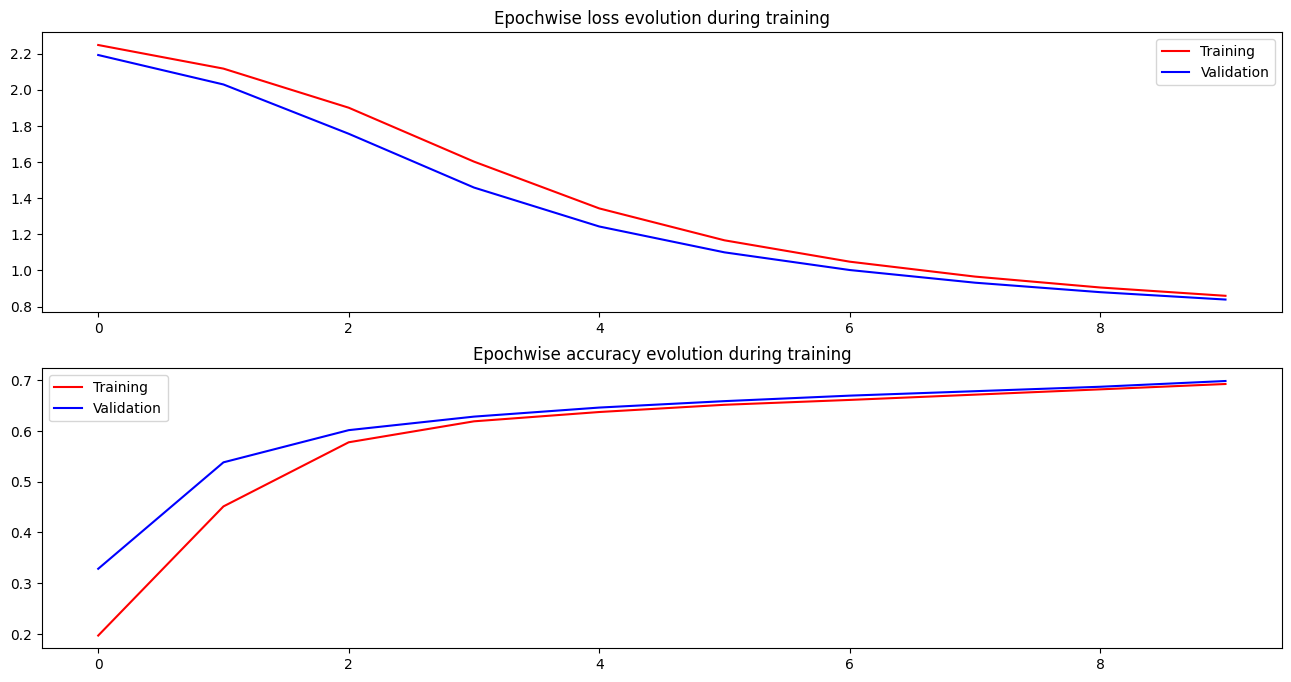

In [11]:
# visualize the training and validation.
train_loss = [report["loss"] for report in full_report["training"]]
train_accuracy = [report["num_true"]/report["num_total"] for report in full_report["training"]]

val_loss = [report["loss"] for report in full_report["validation"]]
val_accuracy = [report["num_true"]/report["num_total"] for report in full_report["validation"]]

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
axs[0].set_title("Epochwise loss evolution during training")
axs[0].plot(range(param_dict["num_epochs"]), train_loss, c="r", label="Training")
axs[0].plot(range(param_dict["num_epochs"]), val_loss, c="b", label="Validation")
axs[0].legend()

axs[1].set_title("Epochwise accuracy evolution during training")
axs[1].plot(range(param_dict["num_epochs"]), train_accuracy, c="r", label="Training")
axs[1].plot(range(param_dict["num_epochs"]), val_accuracy, c="b", label="Validation")
axs[1].legend()

In [12]:
# load and benchmark results on the best model.
best_model_state_dict = torch.load(
    os.path.join(model_out_path, "best_model.pt"))
best_model = FashionMNISTNet(param_dict).to(device)
best_model.load_state_dict(best_model_state_dict)

print("Testing Started")
test_report = inference_loop(test_loader, best_model, loss_fn, device)

test_loss = test_report['loss']
test_true = test_report['num_true']
test_total = test_report['num_total']
test_accuracy = (test_true/test_total) * 100 

print(f"Test Loss : {test_loss}, Num True : {test_true}, Num Total : {test_total}, Accuracy : {test_accuracy}%")
full_report["testing"] = test_report


Testing Started
Test Loss : 0.8524270551219867, Num True : 6885.0, Num Total : 10000, Accuracy : 68.85%


In [13]:
#save the train, validation and test reports for future reference.
with open(os.path.join(report_out_path, "full_report.pickle"), "wb") as fp:
    pickle.dump(full_report, fp)